In [ ]:
# Data handling and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

# Scale Data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

# Clustering
from sklearn.cluster import KMeans
# from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC 
from torch import nn

# Model evaluation
from sklearn import metrics

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Setup

In [ ]:
data = pd.read_csv("../results/cardiovascular_disease_clean.csv")
data.columns = ["Age(years)", "Gender", "Height(cm)", "Weight(kg)", "SystolicPressure", "DiastolicPressure", "Cholesterol", "Glucose", "Smoke", "Alcohol", "Active", "cardio_disease", "BMI", "Pulse"]

for col in ["Smoke", "Alcohol", "Active", "cardio_disease"]:
    data[col] = data[col].map({'No': 0, 'Yes': 1})

for col in ["Cholesterol", "Glucose"]:
    data[col] = data[col].map({'Normal': 1, 'Above-Normal': 2, 'Well-Above-Normal':3})

# We previously found that gender and height doesn't apport information we discard it
train_data = data.drop(columns=["Gender", "Height(cm)", "cardio_disease"])
cardio_disease = data.loc[:,"cardio_disease"]

train_data

,Age(years),Weight(kg),SystolicPressure,DiastolicPressure,Cholesterol,Glucose,Smoke,Alcohol,Active,BMI,Pulse
0,50.391781,62.0,110,80,1,1,0,0,1,21.967120,30
1,55.419178,85.0,140,90,3,1,0,0,1,34.927679,50
2,51.663014,64.0,130,70,3,1,0,0,0,23.507805,60
3,48.282192,82.0,150,100,1,1,0,0,1,28.710479,50
4,47.873973,56.0,100,60,1,1,0,0,0,23.011177,40
...,...,...,...,...,...,...,...,...,...,...,...
67235,57.736986,80.0,150,80,1,1,0,0,1,29.384757,70
67236,52.712329,76.0,120,80,1,1,1,0,1,26.927438,40
67237,52.235616,105.0,180,90,3,1,0,1,0,31.353579,90
67238,61.454795,72.0,135,80,1,2,0,0,0,27.099251,55


## Dimensionality reduction

### UMAP

In [ ]:
# Transform data
transformer = umap.UMAP(random_state=42)
umap_data = transformer.fit_transform(train_data)

/home/diegocar/.Apps/miniconda3/envs/DataScience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

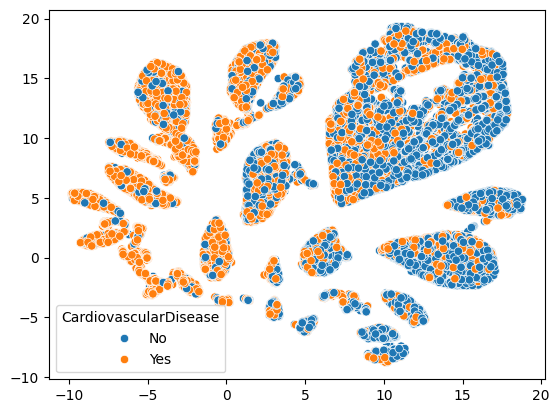

In [ ]:
# Visualize
sns.scatterplot(x=umap_data[:,0], y=umap_data[:,1], hue=cardio_disease)

### t-SNE

In [ ]:
# Transform data
tsne = TSNE(random_state = 42)
tsne_data = tsne.fit_transform(train_data)

<Axes: >

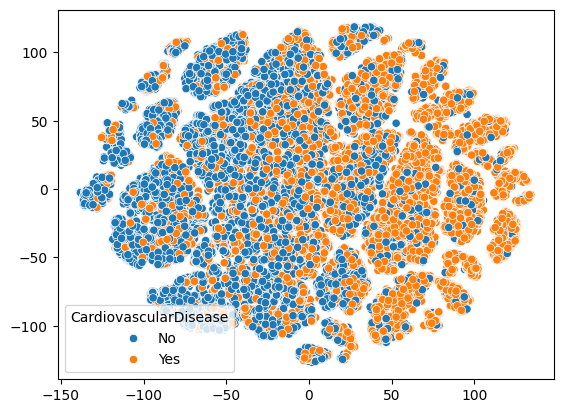

In [ ]:
# Visualize
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=cardio_disease)

### PCA

In [ ]:
# Transform data
pca = PCA(n_components=2)
eigen = pca.fit_transform(train_data)
explained_variance = pca.explained_variance_ratio_

<Axes: >

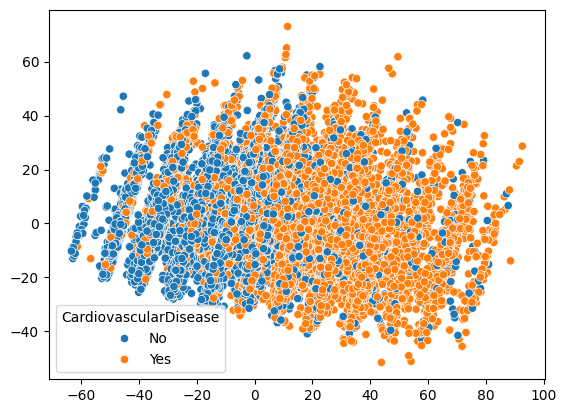

In [ ]:
# Visualize
sns.scatterplot(x=eigen[:,0], y=eigen[:,1], hue=cardio_disease)

In [ ]:
explained_variance

array([0.58803102, 0.23536571])

## Clustering

### K-means

In [11]:
# Choose cluster number
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(train_data)

pred_labels = kmeans.labels_
print(cardio_disease.values)
print(pred_labels)

[0 1 1 ... 1 1 0]
[0 1 0 ... 1 1 0]


In [12]:
print(f"Rand index: {metrics.adjusted_rand_score(cardio_disease, pred_labels)}")
print(f"Homogeneity: {metrics.homogeneity_score(cardio_disease, pred_labels)}")
print(f"Completeness: {metrics.completeness_score(cardio_disease, pred_labels)}")
print(f"V-measure: {metrics.v_measure_score(cardio_disease, pred_labels)}")

Rand index: 0.1551585928096232
Homogeneity: 0.13362540112576887
Completeness: 0.1498309935457247
V-measure: 0.1412649493183823


### Hierarchical

In [ ]:
# sns.clustermap(pre_train_data, method="ward", metric="euclidean", cmap="viridis", standard_scale=1)
# plt.show()

# Z = linkage(pre_train_data, method="ward", metric="euclidean")  # Puedes cambiar método/métrica si lo deseas
# clusters = fcluster(Z, t=2, criterion="maxclust")  # t=2 asegura que solo se formen dos clusters
# pre_train_data["Cluster-Hierarchical"] = clusters

## Models

In [24]:
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_data.values)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(scaled_data, cardio_disease.values, test_size = 0.2, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (53792, 11)
Training Labels Shape: (53792,)
Testing Features Shape: (13448, 11)
Testing Labels Shape: (13448,)


In [25]:
# Evaluation
def model_evaluation(test_labels, model_preds):
    # Evaluación
    print("Evaluation results")
    print(f"Accuracy:{metrics.accuracy_score(test_labels, model_preds)}")
    print(f"F-1 weighted: {metrics.f1_score(test_labels, model_preds)}")
    print(f"Precision: {metrics.precision_score(test_labels, model_preds)}")
    print(f"Recall: {metrics.recall_score(test_labels, model_preds)}")
    print(f"AUROC weighted: {metrics.roc_auc_score(test_labels, model_preds, average='weighted')}")

    # Confusion matrix
    svm_confusion_matrix=confusion_matrix(test_labels, model_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=svm_confusion_matrix)
    disp.plot()
    plt.show()

    # Classification report
    print(metrics.classification_report(test_labels, model_preds))

    # Plot ROC curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels, model_preds)
    auc_roc = metrics.roc_auc_score(test_labels, model_preds, average='weighted')
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % auc_roc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


### Support Vector Machine (SVM)

Evaluation results
Accuracy:0.7246430696014278
F-1 weighted: 0.6921094204706078
Precision: 0.7829194883370956
Recall: 0.6201758307256743
AUROC weighted: 0.724441485201044


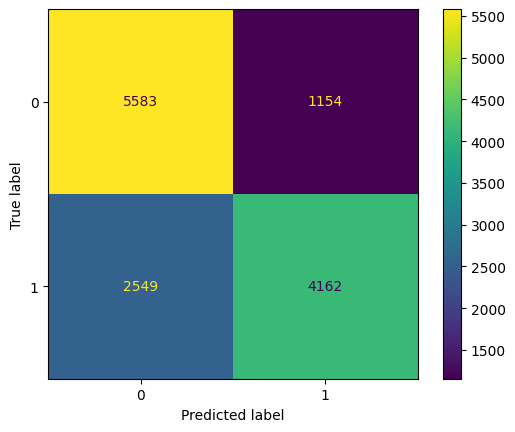

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      6737
           1       0.78      0.62      0.69      6711

    accuracy                           0.72     13448
   macro avg       0.73      0.72      0.72     13448
weighted avg       0.73      0.72      0.72     13448



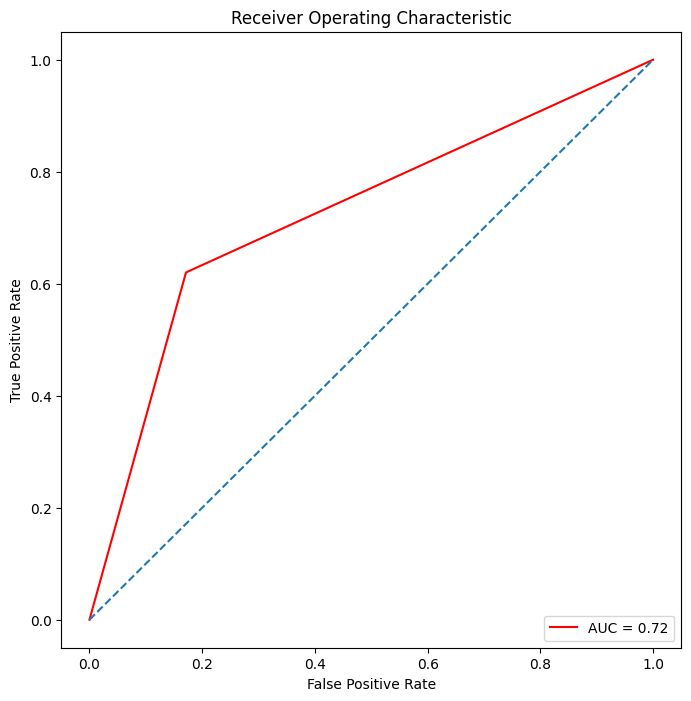

In [26]:
# Fit model
svm = SVC(kernel="linear", C=1.0, random_state=42)
svm.fit(train_features, train_labels)

# Predict
svm_pred = svm.predict(test_features)

# Evaluation
model_evaluation(test_labels, svm_pred)

### Decision Tree

Evaluation results
Accuracy:0.6321386079714456
F-1 weighted: 0.6257659429608896
Precision: 0.6355255070682237
Recall: 0.6163015943972582
AUROC weighted: 0.6321080482005585


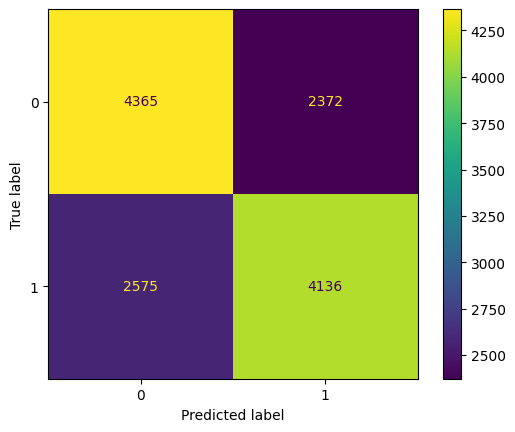

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6737
           1       0.64      0.62      0.63      6711

    accuracy                           0.63     13448
   macro avg       0.63      0.63      0.63     13448
weighted avg       0.63      0.63      0.63     13448



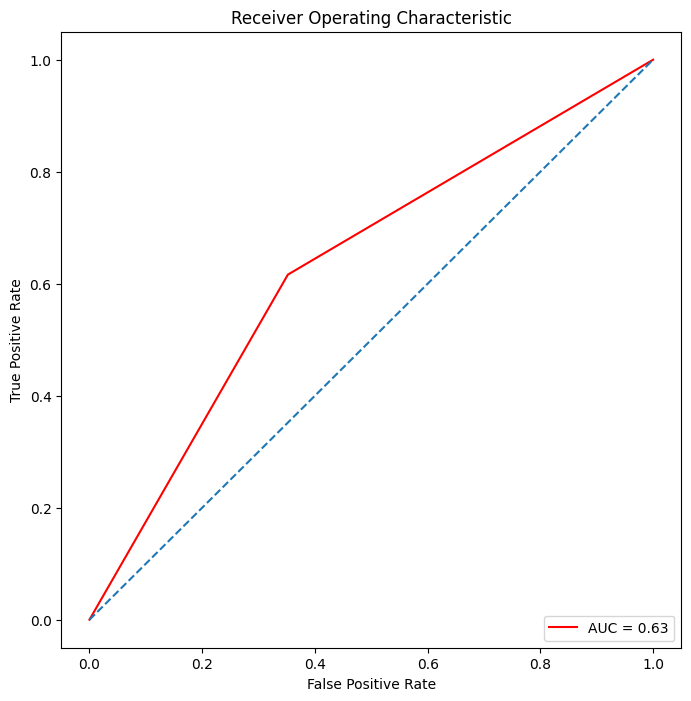

In [10]:
# Fit model
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(train_features, train_labels)

# Predict
dtc_pred = dtc.predict(test_features)

# Evaluation
model_evaluation(test_labels, dtc_pred)

### Random Forest

Evaluation results
Accuracy:0.7077632361689471
F-1 weighted: 0.7001373416755684
Precision: 0.7174354964816263
Recall: 0.6836537028758755
AUROC weighted: 0.7077167133942982


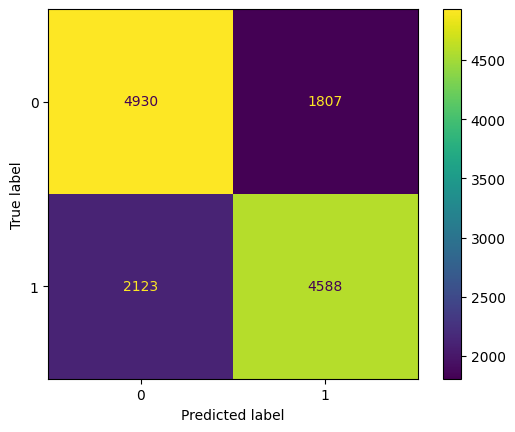

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      6737
           1       0.72      0.68      0.70      6711

    accuracy                           0.71     13448
   macro avg       0.71      0.71      0.71     13448
weighted avg       0.71      0.71      0.71     13448



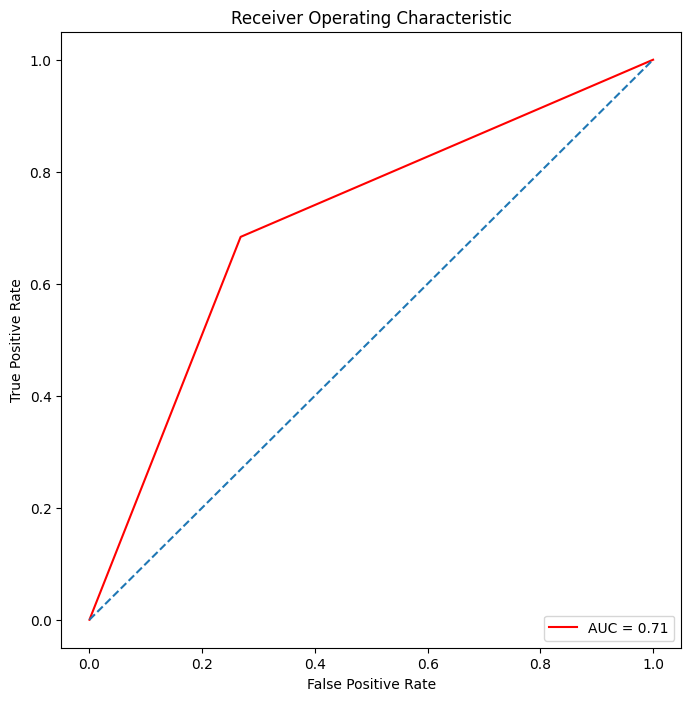

In [11]:
# Fit model
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
rfc.fit(train_features, train_labels)

# Predict
rfc_pred = rfc.predict(test_features)

# Evaluation
model_evaluation(test_labels, rfc_pred)

### Bernoulli Naive Bayes

Evaluation results
Accuracy:0.5145002974419988
F-1 weighted: 0.2851198948866747
Precision: 0.5375722543352601
Recall: 0.19400983459991059
AUROC weighted: 0.513881865496482


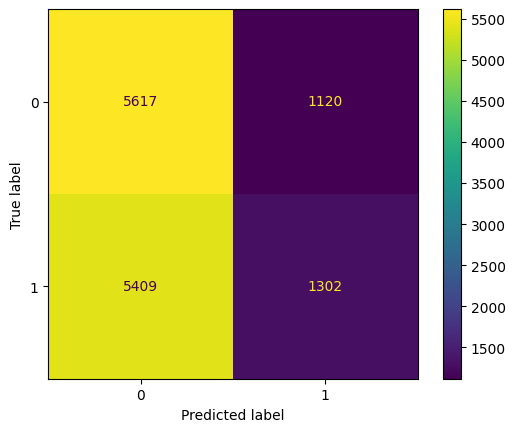

              precision    recall  f1-score   support

           0       0.51      0.83      0.63      6737
           1       0.54      0.19      0.29      6711

    accuracy                           0.51     13448
   macro avg       0.52      0.51      0.46     13448
weighted avg       0.52      0.51      0.46     13448



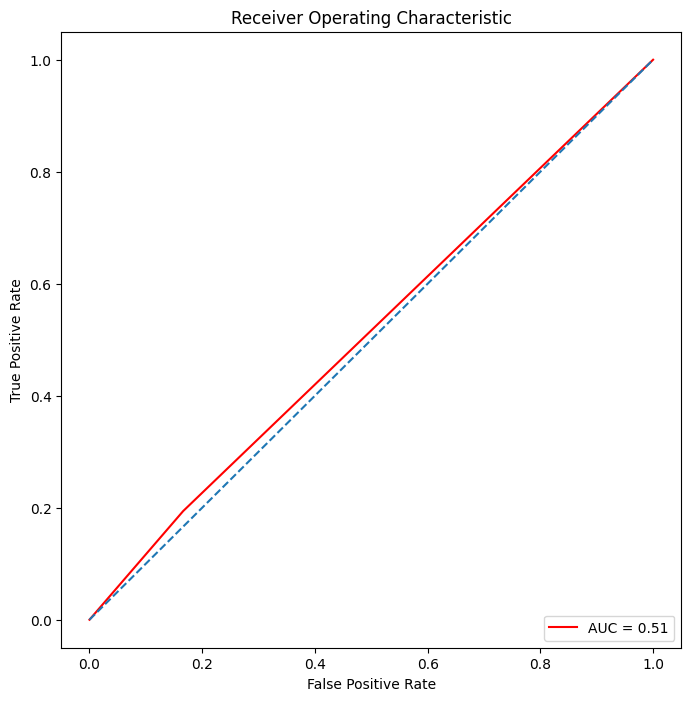

In [14]:
# Fit model
bnb = BernoulliNB()
bnb.fit(train_features, train_labels)

# Predict
bnb_pred = bnb.predict(test_features)

# Evaluation
model_evaluation(test_labels, bnb_pred)

### Multinomial Naive Bayes

Evaluation results
Accuracy:0.5963712076145151
F-1 weighted: 0.5606992554224668
Precision: 0.6136403897254207
Recall: 0.5161674862166592
AUROC weighted: 0.596216443123173


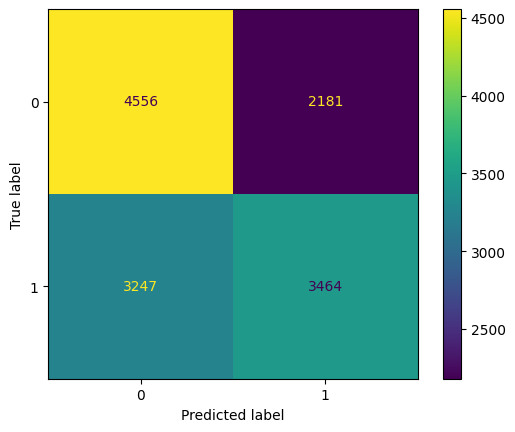

              precision    recall  f1-score   support

           0       0.58      0.68      0.63      6737
           1       0.61      0.52      0.56      6711

    accuracy                           0.60     13448
   macro avg       0.60      0.60      0.59     13448
weighted avg       0.60      0.60      0.59     13448



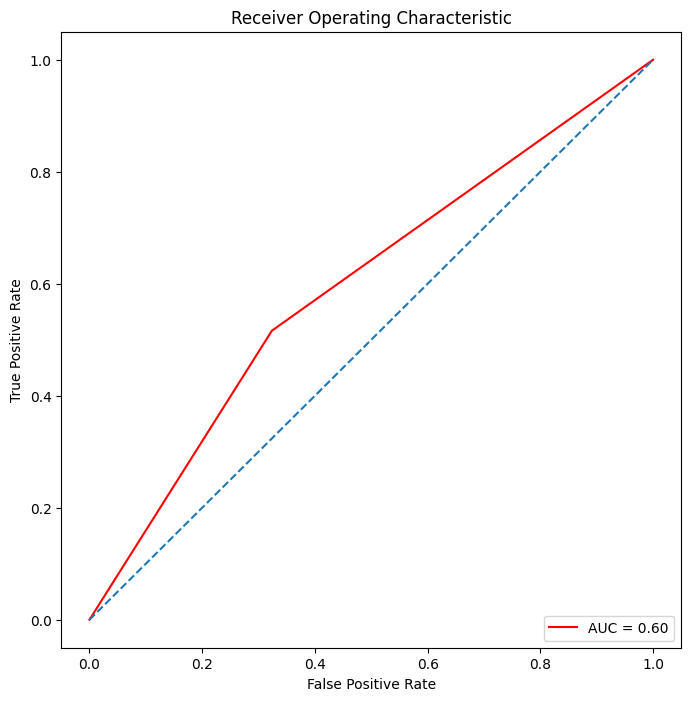

In [15]:
# Fit model
mnb = MultinomialNB()
mnb.fit(train_features, train_labels)

# Predict
mnb_pred = mnb.predict(test_features)

# Evaluation
model_evaluation(test_labels, mnb_pred)

### Neural network

In [33]:
# Define device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device to use: {device}")

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# DataLoader
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#  Define NN
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11, 512),  # 11 input characteristics
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # 2 output classes
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Train function
def train(dataloader, neural_net, loss_fn, optimizer):
    size = len(dataloader.dataset)
    neural_net.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = neural_net(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Función de prueba
def test(dataloader, neural_net, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    neural_net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = neural_net(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # print(f"Fase de prueba:")
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

Device to use: cpu


In [34]:
# Instance neural_net
neural_net = NeuralNet().to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(neural_net.parameters(), lr=1e-3)

# Train model
for t in range(epochs := 5):
    print(f"--------------------\nEpoch {t+1}")
    train(train_dataloader, neural_net, loss_fn, optimizer)
    test(test_dataloader, neural_net, loss_fn)

--------------------
Epoch 1
Accuracy: 72.9%, Avg loss: 0.549823
--------------------
Epoch 2
Accuracy: 73.0%, Avg loss: 0.544784
--------------------
Epoch 3
Accuracy: 73.1%, Avg loss: 0.542487
--------------------
Epoch 4
Accuracy: 73.2%, Avg loss: 0.548443
--------------------
Epoch 5
Accuracy: 73.1%, Avg loss: 0.543554
